In [1]:
import sys, os

# Add KF_scripts to sys.path
KF_SCRIPTS_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
if KF_SCRIPTS_DIR not in sys.path:
    sys.path.append(KF_SCRIPTS_DIR)

print("Added to sys.path:", KF_SCRIPTS_DIR)

# === 1. Imports ===
import pandas as pd
import numpy as np
import plotly.graph_objects as go


Added to sys.path: C:\Users\User\OneDrive\Projects\TradingSystem\KF_TradingSystem


In [36]:
from src.data.data_utils import process_raw_to_processed, load_processed_df


# df_proc = process_raw_to_processed("QQQ", "2025-12-03", "2025-12-03", 5, overwrite=True)

df_loaded = load_processed_df("QQQ", "2025-12-03", "2025-12-03", 5)
df_loaded.columns

Processed data saved to:
C:\Users\User\OneDrive\Projects\TradingSystem\Data\ProcessedData\QQQ_2025-12-03_2025-12-03_5.csv
Shape: (4680, 17)


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Mid', 'Spread',
       'var_dMid', 'var_acc', 'Spread_smooth', 'KF_level_adapt',
       'KF_slope_adapt', 'KF_curv_adapt', 'KF_level_var_adapt',
       'KF_slope_var_adapt', 'KF_curv_var_adapt'],
      dtype='object')

In [22]:
from src.data.data_utils import load_processed_df
from src.quant.quant_utils import add_slope_quantiles
from src.signals.signal_utils import (
    add_turning_regions,
    add_slope_peaks,
    add_entry_signals,
    add_exit_signals,
    add_level_peaks,
    add_raw_slope_peaks,
    add_trade_ids
)
from src.visualization.plot_utils import plot_price_signals

df_proc = load_processed_df(
    symbol="QQQ",
    start="2025-11-20",
    end="2025-12-01",
    interval=5,
)

# Quantiles
df_proc = add_slope_quantiles(df_proc)  # adds slope_q_roll

# Regions & peaks
df_proc = add_turning_regions(df_proc, q_col="slope_q_roll", Q_high=0.90)
df_proc = add_slope_peaks(df_proc)
df_proc = add_raw_slope_peaks(df_proc)         # exit peaks (not filtered)
# df_proc = add_level_peaks(df_proc) 

# Entries & exits
df_proc = add_entry_signals(df_proc)
df_proc = add_exit_signals(df_proc, max_adverse_bars=5)
df_proc = add_trade_ids(df_proc)

# Quick sanity check
df_proc[["entry_long", "exit_long", "entry_short", "exit_short"]].sum()
# df_proc[["entry_long", "entry_short",]].sum()

entry_long     140
exit_long      140
entry_short    161
exit_short     161
dtype: int64

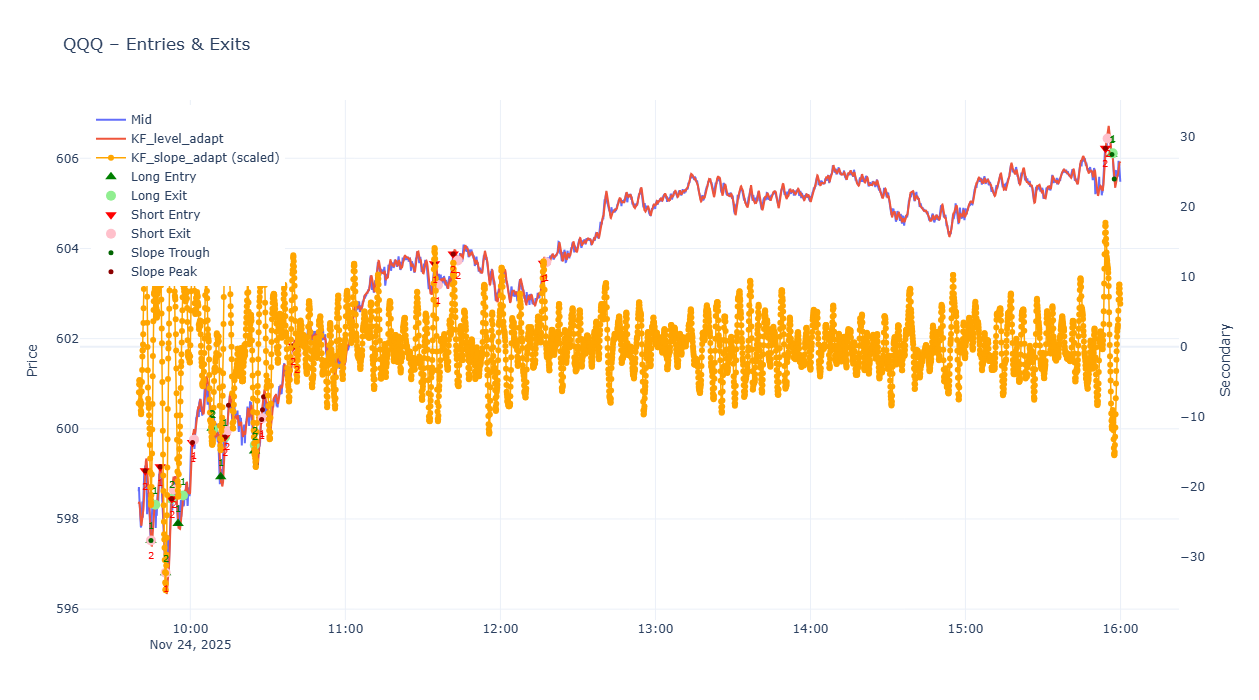

In [32]:
start = '2025-11-24 09:40:00-05:00'
end   = '2025-11-24 15:59:55-05:00'
df_range = df_proc[(df_proc.index >= start) & (df_proc.index <= end)]

plot_price_signals(
    df_range,
    price_cols=("Mid", "KF_level_adapt"),
    secondary_cols=("KF_slope_adapt",),
    secondary_scale=1000,
    show_peaks=True,
    title="QQQ – Entries & Exits"
)

In [33]:

long_pnl = df_range.loc[df_range["exit_long"], "Mid"].sum() \
           - df_range.loc[df_range["entry_long"], "Mid"].sum()

short_pnl = df_range.loc[df_range["entry_short"], "Mid"].sum() \
            - df_range.loc[df_range["exit_short"], "Mid"].sum()

total_pnl=long_pnl+short_pnl

print(df_range[["entry_long", "exit_long", "entry_short", "exit_short"]].sum())

long_pnl,short_pnl,total_pnl

entry_long      7
exit_long       7
entry_short    11
exit_short     11
dtype: int64


(np.float64(4.075000000000728),
 np.float64(4.015000000001237),
 np.float64(8.090000000001965))